# Energy calculations

In [1]:
# make sure scipy is available in thebe: numpy and matplotlib available by default
%pip install scipy

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


Note: you may need to restart the kernel to use updated packages.


## Module

In [2]:
# %load glsp.py
# glsp.py: code to solve GL BVP and plot psi and b.

import numpy as np
from scipy.integrate import solve_bvp,quad
import matplotlib.pyplot as plt

def nat(x,h): # natural BC with applied magnetizing field h
  def BC(Y):
    return [Y[1],Y[3]-h]
  return (x,BC)

def inf(x): # 'infinity' BC with b=da=0 f=1 or 0 at x='infinity'
  def BC(Y):
    return [Y[1],Y[3]]
  return (x,BC)

def nrm(x,r,h): # normal metal BC with parameter r.
  def BC(Y):
    return [Y[1]-r*Y[0],Y[3]-h]
  return (x,BC)

def SCP(x): # superconducting psi=1,b proportional to exp(-x), for x going to +infinity.
  def BC(Y):
    return [Y[1]+2**(1/2)*kappa*(Y[0]-1),Y[3]+Y[2]]
  return (x,BC)

def NCM(x,h): # normal psi=0 with applied field h
  def BC(Y):
    r2=Y[2]**2+Y[0]**2-1
    return [Y[1]-kappa*r2**(1/2)*Y[0],Y[3]-h]
  return (x,BC)

def glsol(kappa,A,B):
  xa,AB=A
  xb,BB=B
  nodes=5
  def dY(x,Y): # Y=[f,df,a,b=da]
    f,df,a,b = Y
    return np.vstack((df, kappa*kappa*f*(f**2+a**2-1),b,a*f**2))
  def bc(Ya, Yb):
    return np.array(AB(Ya)+BB(Yb))
  rng=[xa, xb]
  X = np.linspace(*rng, nodes)
  Y0=[1 if x<0 else 1 for x in X]
  Y = np.vstack([Y0,np.zeros((3, X.size))])
  return solve_bvp(dY, bc, X, Y)

def glplot(kappa,A,B,tex):
  sol=glsol(kappa,A,B)
  x_plot = np.linspace(A[0],B[0], 100)
  y_plot = sol.sol(x_plot)[0] # f
  plt.plot(x_plot, y_plot,label=f"$\psi: {tex}$")
  y_plot = sol.sol(x_plot)[3] # b=da
  plt.plot(x_plot, y_plot,label=f"$b: {tex}$")
  if not sol.success:
    print(f"kappa={kappa},tex={tex}:",sol.message)

In [3]:
def G1(kappa,h0,L):
  A=nat(0,h0)
  B=nat(L,h0)
  sol=glsol(kappa,A,B)
  def g(x):
    f,df,a,da=sol.sol(x)
    return -f**2+f**4/2+(df/kappa)**2+(a*f)**2+da**2-2*h0*da
  return quad(g,0,L)

The Gibbs free energy density in one dimension in scaled variables is:

$$G_1[\psi,\psi^*,\mathbf a]=\frac {H_c^2}{4\pi}\lambda_L^d\int d^d\mathbf r \left[-\psi^2+\frac 12\psi^4+\left(\frac{\psi'}{\kappa}\right)^2+(a\psi)^2+(a')^2-2ha'\right]=\frac {H_c^2}{4\pi}\lambda_L\int g_1dx$$



In the non-superconducting normal state (N) $\psi=0$ and $a'=h$, so $g_{N1}=-h^2$

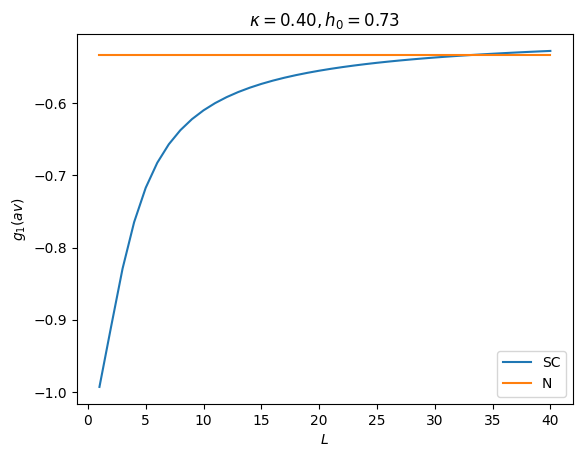

In [4]:
h0=0.73
kappa=.4
plot=[(G1(kappa,h0,L)[0]/L,-h0**2) for L in range(1,41)]
L=list(range(1,41))
plt.plot(L,plot,label=["SC","N"])
plt.xlabel("$L$")
plt.ylabel("$g_1(av)$")
plt.title(f"$\kappa={kappa:.2f}, h_0={h0:.2f}$")
plt.legend()
plt.show()

The approach to &lsquo;bulk&rsquo; behaviour is sllooowwww. This seems to enable superconducting behaviour to occur above the critical applied field for thin slabs. A sort of "surface tension" effect? Above $\kappa=0.4$ the code starts throwing wobblies?

## Arovas' partial integration

The Gibbs free energy can be partially integrated as:

$$G_1[\psi,\psi^*,\mathbf a]=\frac {H_c^2}{4\pi}\lambda_L^d\int d^d\mathbf r \left[-\psi^2+\frac 12\psi^4-\frac{\psi\psi''}{\kappa^2}+(a\psi)^2+(a')^2-2ha'\right]=\frac {H_c^2}{4\pi}\lambda_L\int g_1dx$$

but for a solution of the GL equations:

$$\frac{\psi''}{\kappa^2}-(a^2+\psi^2-1)\psi=0$$

and we can reduce:

$$G_1[\psi,\psi^*,\mathbf a]=\frac {H_c^2}{4\pi}\lambda_L^d\int d^d\mathbf r \left[-\frac 12\psi^4+(a')^2-2ha'\right]=\frac {H_c^2}{4\pi}\lambda_L\int g_1dx$$

For now I assume the partially integrated term $[\psi\psi'/\kappa^2]$ is zero. This is true both for the natural boundary condition ($\psi'=0$) and if the $\psi$ value is zero.

In [5]:
def G1A(kappa,h0,L):
  A=nat(0,h0)
  B=nat(L,h0)
  sol=glsol(kappa,A,B)
  def g(x):
    f,df,a,da=sol.sol(x)
    return -f**4/2+da**2-2*h0*da
  return quad(g,0,L)

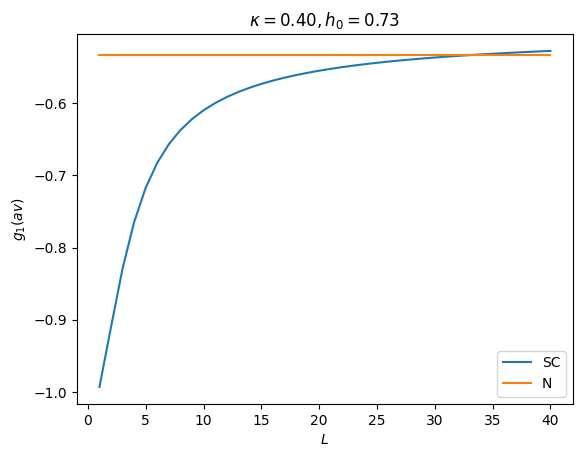

In [6]:
h0=0.73
kappa=.4
plot=[(G1A(kappa,h0,L)[0]/L,-h0**2) for L in range(1,41)]
L=list(range(1,41))
plt.plot(L,plot,label=["SC","N"])
plt.xlabel("$L$")
plt.ylabel("$g_1(av)$")
plt.title(f"$\kappa={kappa:.2f}, h_0={h0:.2f}$")
plt.legend()
plt.show()

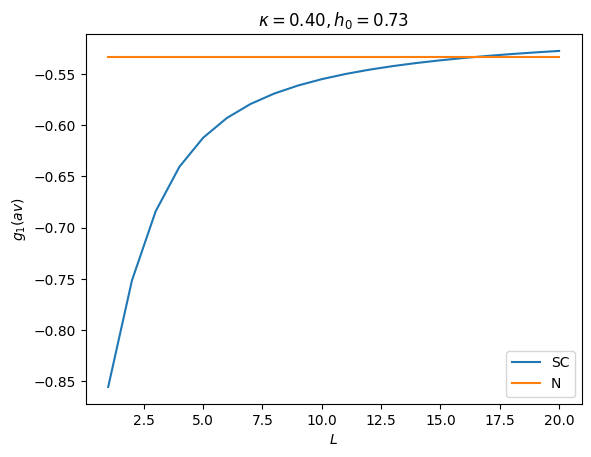

In [7]:
def G1ABA(kappa,h0,A,B):
  sol=glsol(kappa,A,B)
  def g(x):
    f,df,a,da=sol.sol(x)
    return -f**4/2+da**2-2*h0*da  
  return quad(g,A[0],B[0])

h0=0.73
kappa=.4
L=list(range(1,21))
plot=[(G1ABA(kappa,h0,nat(0,h0),SCP(l))[0]/l,-h0**2) for l in L]
plt.plot(L,plot,label=["SC","N"])
plt.xlabel("$L$")
plt.ylabel("$g_1(av)$")
plt.title(f"$\kappa={kappa:.2f}, h_0={h0:.2f}$")
plt.legend()
plt.show()

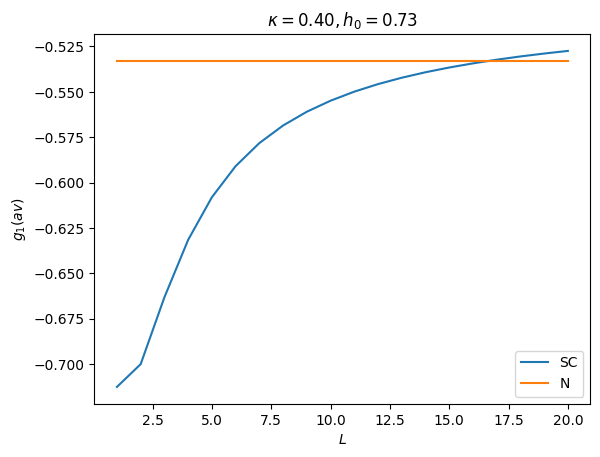

In [8]:
def G1AB(kappa,h0,A,B):
  sol=glsol(kappa,A,B)
  def g(x):
    f,df,a,da=sol.sol(x)
    return -f**2+f**4/2+(df/kappa)**2+(a*f)**2+da**2-2*h0*da 
  return quad(g,A[0],B[0])

h0=0.73
kappa=.4
L=list(range(1,21))
plot=[(G1AB(kappa,h0,nat(0,h0),SCP(l))[0]/l,-h0**2) for l in L]
plt.plot(L,plot,label=["SC","N"])
plt.xlabel("$L$")
plt.ylabel("$g_1(av)$")
plt.title(f"$\kappa={kappa:.2f}, h_0={h0:.2f}$")
plt.legend()
plt.show()

The original form has a kink near the beginning. Is this due to SCP not being &lsquo;natural&rsquo; for such short ranges?